In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models, datasets
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

train_dir = "/kaggle/input/butterflies/train_butterflies/"
test_dir = "/kaggle/input/butterflies/test_butterflies/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16

In [12]:
# функция для рисования кривых обучения
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(train_loss, label='Train Loss', linewidth=2)
    axes[0].plot(val_loss, label='Val Loss', linewidth=2)
    axes[0].set_title('Loss per Epoch', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(loc='upper right', fontsize=10)

    axes[1].plot(train_acc, label='Train Accuracy', linewidth=2)
    axes[1].plot(val_acc, label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy per Epoch', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(loc='lower right', fontsize=10)

    plt.show()

In [13]:
# тренировка модели
def train_model(model, num_epochs, optimizer, criterion, name, scheduler=None):
    max_acc = 0
    
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        # тренировка
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        train_loss /= len(train_loader)
        
        # валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        val_loss /= len(val_loader)

        if scheduler is not None:
            scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
    
        if max_acc < val_acc:
            max_acc = val_acc
            torch.save(model.state_dict(), name)

    plot_training_curves(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [14]:
# первая модель в ансамбле
class ButterflyClassifierUpdated(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b3(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(self.base_model.classifier[1].in_features, 50)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # статистика ImageNet
])

aug_transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=None
)

train_tmp, val_tmp = random_split(train_dataset, [0.8, 0.2])

In [16]:
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_ds = TransformSubset(train_tmp, aug_transform)
val_ds = TransformSubset(val_tmp, transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Epoch 1/20: 100%|██████████| 248/248 [01:30<00:00,  2.76it/s]


Train Loss: 3.6221 | Acc: 18.92%
Val Loss: 9.4899 | Acc: 57.42%


Epoch 2/20: 100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


Train Loss: 2.2420 | Acc: 63.07%
Val Loss: 10.8955 | Acc: 76.99%


Epoch 3/20: 100%|██████████| 248/248 [01:07<00:00,  3.70it/s]


Train Loss: 1.0800 | Acc: 81.63%
Val Loss: 4.0437 | Acc: 83.65%


Epoch 4/20: 100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


Train Loss: 0.6534 | Acc: 87.46%
Val Loss: 1.2669 | Acc: 88.40%


Epoch 5/20: 100%|██████████| 248/248 [01:07<00:00,  3.67it/s]


Train Loss: 0.4503 | Acc: 90.74%
Val Loss: 0.7643 | Acc: 90.41%


Epoch 6/20: 100%|██████████| 248/248 [01:07<00:00,  3.70it/s]


Train Loss: 0.3387 | Acc: 92.56%
Val Loss: 0.6933 | Acc: 92.43%


Epoch 7/20: 100%|██████████| 248/248 [01:06<00:00,  3.71it/s]


Train Loss: 0.2798 | Acc: 94.15%
Val Loss: 0.9791 | Acc: 92.43%


Epoch 8/20: 100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


Train Loss: 0.2421 | Acc: 94.35%
Val Loss: 0.3639 | Acc: 92.63%


Epoch 9/20: 100%|██████████| 248/248 [01:06<00:00,  3.73it/s]


Train Loss: 0.1938 | Acc: 95.84%
Val Loss: 0.2873 | Acc: 93.74%


Epoch 10/20: 100%|██████████| 248/248 [01:06<00:00,  3.72it/s]


Train Loss: 0.1580 | Acc: 96.57%
Val Loss: 0.2442 | Acc: 93.54%


Epoch 11/20: 100%|██████████| 248/248 [01:06<00:00,  3.72it/s]


Train Loss: 0.1483 | Acc: 96.72%
Val Loss: 0.2609 | Acc: 93.14%


Epoch 12/20: 100%|██████████| 248/248 [01:06<00:00,  3.71it/s]


Train Loss: 0.1290 | Acc: 97.07%
Val Loss: 0.2407 | Acc: 93.95%


Epoch 13/20: 100%|██████████| 248/248 [01:06<00:00,  3.74it/s]


Train Loss: 0.1185 | Acc: 97.05%
Val Loss: 0.2258 | Acc: 94.75%


Epoch 14/20: 100%|██████████| 248/248 [01:06<00:00,  3.72it/s]


Train Loss: 0.1083 | Acc: 97.38%
Val Loss: 0.2235 | Acc: 94.65%


Epoch 15/20: 100%|██████████| 248/248 [01:06<00:00,  3.74it/s]


Train Loss: 0.0932 | Acc: 97.86%
Val Loss: 0.2304 | Acc: 94.35%


Epoch 16/20: 100%|██████████| 248/248 [01:05<00:00,  3.77it/s]


Train Loss: 0.0860 | Acc: 97.86%
Val Loss: 0.2383 | Acc: 93.74%


Epoch 17/20: 100%|██████████| 248/248 [01:07<00:00,  3.66it/s]


Train Loss: 0.0781 | Acc: 98.18%
Val Loss: 0.2339 | Acc: 94.65%


Epoch 18/20: 100%|██████████| 248/248 [01:07<00:00,  3.69it/s]


Train Loss: 0.0717 | Acc: 98.23%
Val Loss: 0.2309 | Acc: 94.35%


Epoch 19/20: 100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


Train Loss: 0.0615 | Acc: 98.54%
Val Loss: 0.2356 | Acc: 94.75%


Epoch 20/20: 100%|██████████| 248/248 [01:06<00:00,  3.75it/s]


Train Loss: 0.0622 | Acc: 98.56%
Val Loss: 0.2279 | Acc: 95.06%


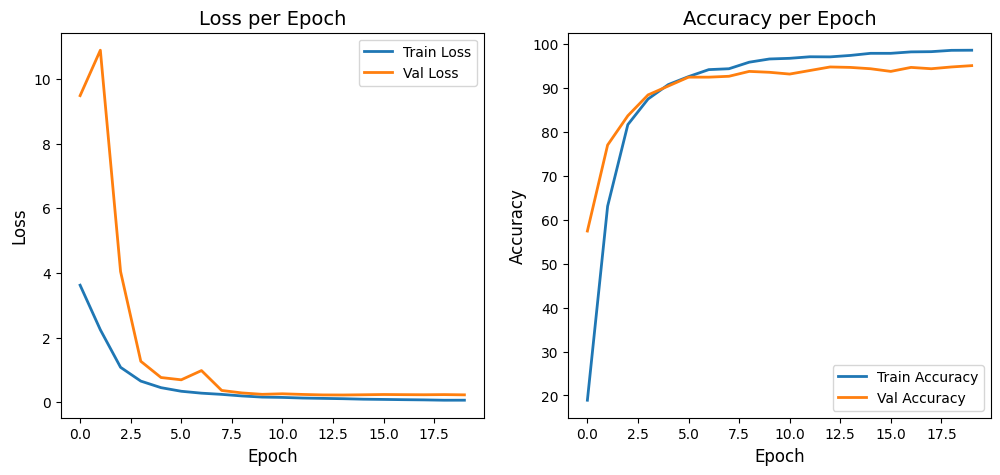

In [17]:
model1 = ButterflyClassifierUpdated().to(device)
opt = optim.Adam(model1.parameters(), lr=0.00005, amsgrad=True)
loss_func = nn.CrossEntropyLoss()
train_model(model1, 20, opt, loss_func, "first_model.pth")

In [18]:
# вторая модель
class ButterflyClassifierResnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.wide_resnet50_2(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(self.base_model.fc.in_features, 50)
        )
    
    def forward(self, x):
        return self.base_model(x)

Epoch 1/20: 100%|██████████| 248/248 [01:18<00:00,  3.17it/s]


Train Loss: 1.6041 | Acc: 65.97%
Val Loss: 0.3749 | Acc: 89.20%


Epoch 2/20: 100%|██████████| 248/248 [01:18<00:00,  3.17it/s]


Train Loss: 0.4322 | Acc: 89.68%
Val Loss: 0.3203 | Acc: 90.31%


Epoch 3/20: 100%|██████████| 248/248 [01:18<00:00,  3.15it/s]


Train Loss: 0.3175 | Acc: 92.28%
Val Loss: 0.3312 | Acc: 92.53%


Epoch 4/20: 100%|██████████| 248/248 [01:18<00:00,  3.14it/s]


Train Loss: 0.2418 | Acc: 93.82%
Val Loss: 0.3002 | Acc: 92.63%


Epoch 5/20: 100%|██████████| 248/248 [01:19<00:00,  3.14it/s]


Train Loss: 0.1847 | Acc: 95.31%
Val Loss: 0.3450 | Acc: 92.43%


Epoch 6/20: 100%|██████████| 248/248 [01:19<00:00,  3.12it/s]


Train Loss: 0.1560 | Acc: 95.99%
Val Loss: 0.3223 | Acc: 92.84%


Epoch 7/20: 100%|██████████| 248/248 [01:19<00:00,  3.14it/s]


Train Loss: 0.1474 | Acc: 95.79%
Val Loss: 0.3676 | Acc: 91.62%


Epoch 8/20: 100%|██████████| 248/248 [01:18<00:00,  3.16it/s]


Train Loss: 0.1404 | Acc: 96.44%
Val Loss: 0.3870 | Acc: 91.62%


Epoch 9/20: 100%|██████████| 248/248 [01:19<00:00,  3.13it/s]


Train Loss: 0.1518 | Acc: 95.74%
Val Loss: 0.3783 | Acc: 91.73%


Epoch 10/20: 100%|██████████| 248/248 [01:18<00:00,  3.16it/s]


Train Loss: 0.1224 | Acc: 96.72%
Val Loss: 0.3314 | Acc: 92.33%


Epoch 11/20: 100%|██████████| 248/248 [01:19<00:00,  3.13it/s]


Train Loss: 0.1016 | Acc: 97.05%
Val Loss: 0.3055 | Acc: 94.25%


Epoch 12/20: 100%|██████████| 248/248 [01:18<00:00,  3.14it/s]


Train Loss: 0.0829 | Acc: 97.88%
Val Loss: 0.3397 | Acc: 92.63%


Epoch 13/20: 100%|██████████| 248/248 [01:19<00:00,  3.13it/s]


Train Loss: 0.0693 | Acc: 98.39%
Val Loss: 0.3530 | Acc: 93.95%


Epoch 14/20: 100%|██████████| 248/248 [01:18<00:00,  3.14it/s]


Train Loss: 0.0691 | Acc: 97.91%
Val Loss: 0.3694 | Acc: 94.15%


Epoch 15/20: 100%|██████████| 248/248 [01:18<00:00,  3.15it/s]


Train Loss: 0.0515 | Acc: 98.59%
Val Loss: 0.4075 | Acc: 93.44%


Epoch 16/20: 100%|██████████| 248/248 [01:19<00:00,  3.13it/s]


Train Loss: 0.0671 | Acc: 98.13%
Val Loss: 0.3350 | Acc: 94.15%


Epoch 17/20: 100%|██████████| 248/248 [01:18<00:00,  3.15it/s]


Train Loss: 0.0459 | Acc: 98.54%
Val Loss: 0.3253 | Acc: 94.45%


Epoch 18/20: 100%|██████████| 248/248 [01:18<00:00,  3.15it/s]


Train Loss: 0.0462 | Acc: 98.64%
Val Loss: 0.3737 | Acc: 93.84%


Epoch 19/20: 100%|██████████| 248/248 [01:18<00:00,  3.18it/s]


Train Loss: 0.0443 | Acc: 98.84%
Val Loss: 0.3481 | Acc: 94.55%


Epoch 20/20: 100%|██████████| 248/248 [01:18<00:00,  3.16it/s]


Train Loss: 0.0312 | Acc: 99.27%
Val Loss: 0.3670 | Acc: 93.95%


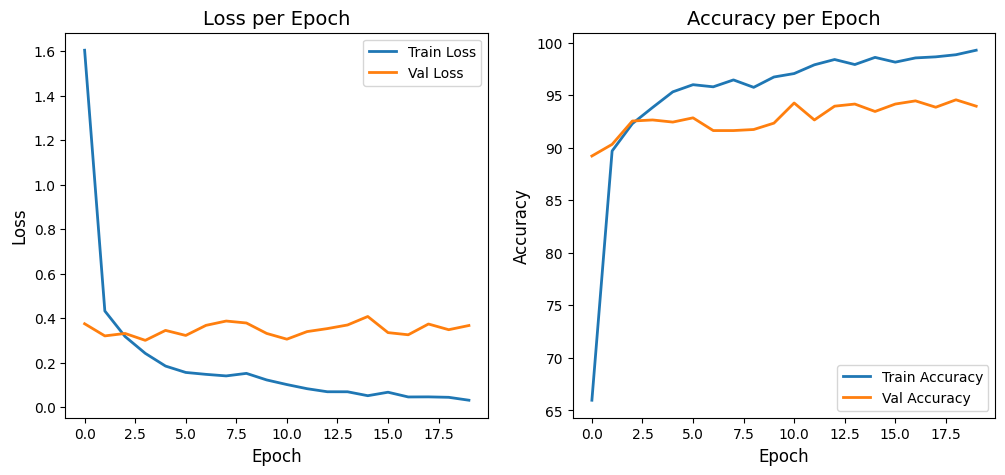

In [19]:
model2 = ButterflyClassifierResnet().to(device)
opt = optim.Adam(model2.parameters(), lr=0.0001, amsgrad=True)
loss_func = nn.CrossEntropyLoss()
train_model(model2, 20, opt, loss_func, "second_model.pth")

In [20]:
class FinalModel(nn.Module):
    def __init__(self, model1, model2):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        
    def forward(self, x):
        preds1 = self.model1(x)
        preds2 = self.model2(x), dim=1
        
        return (preds1 + preds2) / 2 # возвращаем логиты для корректной работы функции потерь

In [21]:
model1.load_state_dict(torch.load('/kaggle/working/first_model.pth'))
model2.load_state_dict(torch.load('/kaggle/working/second_model.pth'))

model1.eval()
model2.eval()

final_model = FinalModel(model1, model2).to(device)

In [23]:
val_loss = 0.
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        loss = loss_func(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_acc = 100. * correct / total
val_loss /= len(val_loader)

print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

Val Loss: 3.0100 | Acc: 95.26%
